In [1]:
!pip install pyqubo

     |████████████████████████████████| 884 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 396 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 845 kB/s eta 0:00:01
     |████████████████████████████████| 81 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 772 kB 3.8 MB/s eta 0:00:01


In [3]:
from qat.lang.AQASM import Program, CNOT, H, RX, RY, RZ
from qat.qpus import get_default_qpu
import numpy as np
from numpy import linalg
from qat.qpus import PyLinalg
import qiskit
from qiskit import *
from qiskit.aqua.components.optimizers import COBYLA,SLSQP,SPSA
from qiskit.visualization import plot_histogram
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import scipy
from scipy import optimize

%matplotlib inline

# Otimização de Portfólio

A função objetivo para a otimização de portfólio pode ser modelada como uma função quadrática binária irrestrita. Essa função,termos do retorno, orçamento total e a matriz de covariância do portfólio, pode ser expressa como

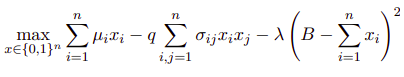

## 1. Quantum Approximate Optimization Algorithm (QAOA)

In [4]:
#matriz de covariante usada no problema clássico
cov  = [[1.08774352e-03, 2.59532811e-04, 1.80247155e-04, 3.21724369e-04],
       [2.59532811e-04, 4.43192629e-04, 7.43211072e-05, 2.27911525e-04],
       [1.80247155e-04, 7.43211072e-05, 3.89444953e-04, 1.37915422e-04],
       [3.21724369e-04, 2.27911525e-04, 1.37915422e-04, 8.75437564e-04]]

#retornos
mu  = [0.31542042, 0.0571331 , 0.11430001, 0.30109367]

# parâmetros da função objetiva
q   = 0.5
B   = 2
lamb= 1

#cria as variáveis binárias
from pyqubo import Spin, Binary
s1, s2, s3, s4 = Spin("s1"), Spin("s2"), Spin("s3"), Spin("s4")
x1, x2, x3, x4 = Binary("x1"), Binary("x2"), Binary("x3"), Binary("x4")
#
X=[x1,x2,x3,x4]

# escreve o QUBO
EN = (mu[0]*X[0] + mu[1]*X[1] + mu[2]*X[2] + mu[3]*X[3] - 
         q*(cov[0][1]*X[0]*X[1] + cov[0][2]*X[0]*X[2] + cov[0][3]*X[0]*X[3] + cov[1][2]*X[1]*X[2] + 
        cov[1][3]*X[1]*X[3] + cov[2][3]*X[2]*X[3]) - 
             lamb*(B - X[0] - X[1] - X[2] - X[3]))

# cria o modelo e transforma de QUBO para Ising
model = EN.compile()
linear, quadratic, offset = model.to_ising()

# coeficientes que serão usados no Operador Gamma
coefs=[linear['x1'],linear['x2'],linear['x3'],linear['x4'],
      quadratic[('x1', 'x2')],quadratic[('x3', 'x1')],quadratic[('x4', 'x1')],
       quadratic[('x3', 'x2')], quadratic[('x4', 'x2')],quadratic[('x4', 'x3')]]



In [27]:
# OBS: NESSA CÉLULA, O QISKIT É USADO APENAS PARA VIZUALIZAÇÃO DO CIRCUITO

num_assets=4
def gamma_op(gamma):
    num_q=num_assets
    qc_gamma=QuantumCircuit(num_q)
    # iteration between p0 and p1
    
    for i in range(num_q):
        for j in range(num_q):
            if(i<j):
                qc_gamma.cx(i,j)
                qc_gamma.rz(gamma*coefs[j+4],j)
                qc_gamma.cx(i,j)
    qc_gamma.barrier()
    for i in range(num_q):
        qc_gamma.rz(coefs[i],i)

    return qc_gamma

guess=0
gamma_op(guess).draw(fold=-1)

░ ┌─────────────┐
q_0: ──■─────────────■────■─────────────■────■──────────────────────■──────────────────────────────────────────────░─┤ Rz(0.65762) ├
     ┌─┴─┐┌───────┐┌─┴─┐  │             │    │                      │                                              ░ └┬────────────┤
q_1: ┤ X ├┤ Rz(0) ├┤ X ├──┼─────────────┼────┼──────■───────────────┼────■────■─────────────■──────────────────────░──┤ Rz(0.5285) ├
     └───┘└───────┘└───┘┌─┴─┐┌───────┐┌─┴─┐  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐  │             │                      ░  ├────────────┤
q_2: ───────────────────┤ X ├┤ Rz(0) ├┤ X ├──┼────┤ X ├──┤ Rz(0) ├──┼──┤ X ├──┼─────────────┼────■─────────────■───░──┤ Rz(0.5571) ├
                        └───┘└───────┘└───┘┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘┌─┴─┐┌───────┐┌─┴─┐┌─┴─┐┌───────┐┌─┴─┐ ░ ┌┴────────────┤
q_3: ──────────────────────────────────────┤ X ├┤ Rz(0) ├─────────┤ X ├─────┤ X ├┤ Rz(0) ├┤ X ├┤ X ├┤ Rz(0) ├┤ X ├─░─┤ Rz(0.65046) ├
                                           └───┘└───────┘         └───┘     └───┘└───────┘└───┘└───┘└───────┘└───┘ ░ └─────────────┘

In [6]:
# IMPLEMENTAÇÃO DO CIRCUITO VARIACIONAL NO MYQLM
def var_circuit(gamma, beta, num_layers, num_qubits):
    qprog = Program()    
    qubits = qprog.qalloc(num_qubits)
    
    #estado inicial: |+>^n
    for qubit in range(num_qubits):
        qprog.apply(H, qubits[qubit])

    for layer in range(num_layers):            
        #operador gamma
        
        for i in range(num_qubits):
            for j in range(num_qubits):
                if(i<j):
                    qprog.apply(CNOT, qubits[i], qubits[j])
                    qprog.apply(RZ(gamma[layer]*coefs[j+4]), qubits[j])
                    qprog.apply(CNOT, qubits[i], qubits[j])
        for i in range(num_qubits):
            qprog.apply(RZ(gamma[layer]*coefs[i]), qubits[i])
        
        # operador beta (forma variacional: emaranhamento linear)
        for i in range(num_qubits):
            qprog.apply(RY(beta[layer]), qubits[i])        
        for i in range(num_qubits-1):
            qprog.apply(CNOT, qubits[i], qubits[i+1])
        qprog.apply(CNOT, qubits[num_qubits-1], qubits[0])        
        for i in range(num_qubits):
            qprog.apply(RY(beta[layer]), qubits[i])
    
    return qprog

In [7]:
num_assets = 4
num_qubits = num_assets
num_layers = 8
gamma_size = num_layers
beta_size  = num_layers

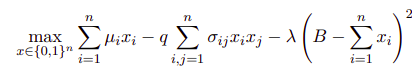

In [8]:
# ENERGIAS DO HAMILTONIANO QUE SERÃO CALCULADAS PARA OS AUTOESTADOS MEDIDOS

def energy(x,num_qubits=num_qubits):   
    H = -((mu[0]*x[0]+mu[1]*x[1]+mu[2]*x[2]+mu[3]*x[3]) - 
          q*(cov[0][1]*x[0]*x[1] + cov[0][2]*x[0]*x[2]+ 
             cov[0][3]*x[0]*x[3] + cov[1][2]*x[1]*x[2]+
             cov[1][3]*x[1]*x[3] + cov[2][3]*x[2]*x[3]) - 
              lamb*(B - x[0]-x[1]-x[2]-x[3])**2)
    return H

In [9]:
energy([1,0,0,1])

-0.6163532278155

In [10]:
def cost_function(param):
    circuit=var_circuit(param[:int((len(param)/2))], 
                        param[(int(len(param)/2)):-1], 
                        num_layers=num_layers, 
                        num_qubits=num_qubits).to_circ()
    
    job = circuit.to_job()
    result = get_default_qpu().submit(job)
    states=[]
    probs=[]
    for sample in result:
        #print(sample.state, sample.probability)
        states.append(sample.state)
        probs.append(sample.probability)
    exp_value=0
    for i in range(len(states)):
        exp_value = exp_value + energy(states[i])*probs[i]
        
    return exp_value

In [11]:
cost_function(np.zeros(2*num_layers+1))

0.6061766065486496

In [38]:
n = 2 # tomar a média das n melhores soluções
Hmin_med        = [] # salvar a energia da solução |1001>
prob1001_med    = [] # salvar a probabilidade da solução |1001>
num_seeds       = 5 # tentar num_seeds soluções
num_try         = 21 # fazer de 0 a (num_try-1) camadas
matriz_Hmin     = [] # salvar todas as 10 energias para cada número de camadas
matriz_prob1001 = [] # salvar todas as 10 probabilidades para cada número de camadas

for k in range(num_try):    
    num_layers  = k
    Hmin        = []
    prob1001    = []
    for i in range(num_seeds):
        np.random.seed(i**2)
        guess = np.random.random(2*num_layers+1)
        ret   = scipy.optimize.minimize(cost_function, guess, args=(), method='COBYLA', constraints=(), tol=None, callback=None, options={'rhobeg': 1.0, 'maxiter': 1000, 'disp': False, 'catol': 0.0002})
        Hmin.append(ret['fun'])
        
        check = var_circuit(ret['x'][:int(len(ret['x'])/2)], 
                            ret['x'][int(len(ret['x'])/2):-1], 
                            num_layers=num_layers, 
                            num_qubits=num_qubits)


        circ  = check.to_circ()
        job   = circ.to_job()
        result= get_default_qpu().submit(job)
        states= []
        probs = []
        for sample in result:
            states.append(sample.state)
            probs.append(sample.probability)
        prob1001.append(probs[9])
    
    print("<H>min média dos 2 mín.:   ",np.mean(sorted(Hmin)[:n]), "   PROB |1001> média 3 max.:   ",np.mean(sorted(prob1001)[-n:]))
    Hmin_med.append(np.mean(sorted(Hmin)[:n]))
    prob1001_med.append(np.mean(sorted(prob1001)[-n:]))
    matriz_Hmin.append(Hmin)
    matriz_prob1001.append(prob1001)

<H>min média dos 3 mín.:    0.6061766065486496    PROB |1001> média 3 max.:    0.06249999999999996
<H>min média dos 3 mín.:    0.37973501136709004    PROB |1001> média 3 max.:    0.028326822272647406
<H>min média dos 3 mín.:    -0.14456905989522045    PROB |1001> média 3 max.:    0.025127563862092087
<H>min média dos 3 mín.:    -0.1901190763636908    PROB |1001> média 3 max.:    0.18237811691782355
<H>min média dos 3 mín.:    -0.3395088568771939    PROB |1001> média 3 max.:    0.6152088725275295
<H>min média dos 3 mín.:    -0.4130608383585722    PROB |1001> média 3 max.:    0.39781781893298496
<H>min média dos 3 mín.:    -0.39231470650322176    PROB |1001> média 3 max.:    0.5375191363304616
<H>min média dos 3 mín.:    -0.4176311749714343    PROB |1001> média 3 max.:    0.3658134781470583
<H>min média dos 3 mín.:    -0.4518383527681351    PROB |1001> média 3 max.:    0.42276875996207763
<H>min média dos 3 mín.:    -0.5237473109099406    PROB |1001> média 3 max.:    0.676131869300399
<H

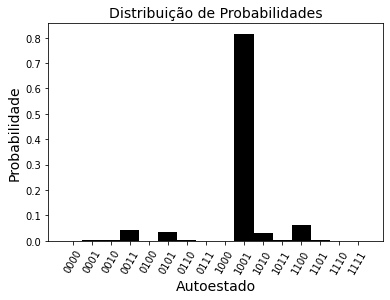

In [44]:
# Plot da distribuição de probabilidades
strings = ['0000','0001','0010','0011','0100','0101','0110','0111',
           '1000','1001','1010','1011','1100','1101','1110','1111']
width   = 1
plt.bar(strings, probs, width=width, color='black')
plt.xlabel('Autoestado',    size=14)
plt.ylabel('Probabilidade', size=14)
plt.title ('Distribuição de Probabilidades', size=14)
plt.xticks(x, strings, rotation=60);

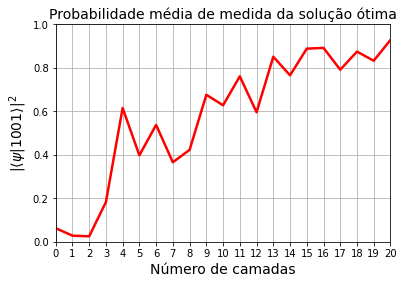

In [40]:
plt.xticks(range(len(prob1001_med)))
plt.plot(range(len(prob1001_med)), prob1001_med, 'r-',linewidth = 2.5 )
plt.title("Probabilidade média de medida da solução ótima", size=14)
plt.ylabel(r'$|\langle\psi|1001\rangle|^2$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 20, 0, 1])
plt.grid(True);

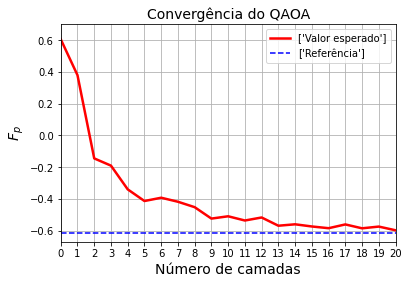

In [42]:
plt.xticks(range(len(Hmin_med)))
plt.plot(range(len(Hmin_med)), Hmin_med, 'r-',linewidth = 2.5)
plt.plot(range(len(Hmin_med)),energy([1,0,0,1])*np.ones(len(Hmin_med)),'b--',linewidth = 1.5)
plt.legend([["Valor esperado"],["Referência"]])
#plt.scatter(range(len(Hmin_avg)), Hmin_avg, color='red')
plt.title("Convergência do QAOA", size=14)
plt.ylabel(r'$F_p$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 20, -0.67, 0.70])
plt.grid(True);

In [36]:
print(Hmin_med)

[0.6061766065486496, 0.1783651012993307, -0.14456905989522045, -0.258217648300124, -0.299585022632576, -0.4102495603490874, -0.4084804283260811, -0.4742735039119902, -0.48396393350477995, -0.5248092976823301, -0.5553998907898297, -0.5748630703192127, -0.5167750458001429, -0.5695833950086492, -0.5597415295842517, -0.5467768851695921, -0.5843224100908995, -0.5938561441610738, -0.5850239878549834, -0.5778439886856939, -0.5974073703610816]


In [37]:
print(prob1001_med)

[0.06249999999999996, 0.04950369215602037, 0.0458578562888704, 0.20197429617288815, 0.4151568200940628, 0.3528412410482049, 0.6449223680778484, 0.6464341450715465, 0.5891148503036481, 0.6908843409410997, 0.7761801936186558, 0.8715814527597993, 0.5958114578832701, 0.8690163999852532, 0.8117884590953903, 0.8017491648892708, 0.891763782514589, 0.9271631567041381, 0.8746234418360955, 0.8700424264619397, 0.9284385390327197]
